In [1]:
import keras
keras.__version__

'2.7.0'

In [2]:
# 뉴스 기사 분류 : 다중 분류 문제
# 로이터 뉴스를 46개의 토픽으로 분류하는 신경망(다중 분류)
# 로이터 데이터셋 : 1986년에 로이터에서 공개한 짧은 뉴스 기사와 토픽의 집합인 데이터셋(케라스 내장 데이터셋)
# 텍스트 분류를 위해 널리 사용되는 간단한 데이터셋
# 46개의 토픽, 각 토픽은 최소 10개의 샘플이 있음
from tensorflow.keras.datasets import reuters

(train_data, train_labels),(test_data, test_labels)=\
    reuters.load_data(num_words=10000) # 데이터 다운로드
# num_words=10000 : 최빈 단어 10,000개만 사용, 드물게 나타나는 단어는 무시

In [3]:
# 8,982개의 학습용 샘플과 2,246개의 검증용 샘플
print(len(train_data))
print(len(test_data))

8982
2246


In [4]:
# 각 샘플은 정수 리스트
train_data[0][:10]

[1, 2, 2, 8, 43, 10, 447, 5, 25, 207]

In [5]:
# 단어 디코딩 예
# 단어 인덱스 다운로드
word_index=reuters.get_word_index()
print(list(word_index.items())[0:10])

# 정수 인덱스와 단어의 순서를 바꾼 리스트
reverse_word_index=dict([(value,key) for (key, value) in word_index.items()])
print(list(reverse_word_index.items())[0:10])

[('mdbl', 10996), ('fawc', 16260), ('degussa', 12089), ('woods', 8803), ('hanging', 13796), ('localized', 20672), ('sation', 20673), ('chanthaburi', 20675), ('refunding', 10997), ('hermann', 8804)]
[(10996, 'mdbl'), (16260, 'fawc'), (12089, 'degussa'), (8803, 'woods'), (13796, 'hanging'), (20672, 'localized'), (20673, 'sation'), (20675, 'chanthaburi'), (10997, 'refunding'), (8804, 'hermann')]


In [6]:
# 레이블은 토픽의 인덱스로 0과 45 사이의 정수
train_labels[10]

3

In [7]:
# 데이터 준비
# 데이터를 벡터로 변환
import numpy as np

np.random.seed(5) # 랜덤시드 고정
def vectorize_sequences(sequences, dimension=10000):
    # 크기가 (len(sequences), dimension)이고 모든 원소가 0인 행렬을 생성, 제로 패딩
    results=np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence]=1. # result[i]에서 특정 인덱스의 위치를 1로 나머지는 0으로 채움(원핫인코딩)
    return results
x_train=vectorize_sequences(train_data) # 학습용 데이터를 2차원 벡터(행렬)로 변환
x_test=vectorize_sequences(test_data) # 검증용 데이터를 2차원 벡터(행렬)로 변환

In [8]:
# one hot encoding : 범주형 데이터에 널리 사용되는 방법
#                    각 레이블의 인덱스 자리는 1이고 나머지는 모두 0인 벡터
def to_one_hot(labels, dimension=46):
    results=np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label]=1.
    return results
one_hot_train_labels=to_one_hot(train_labels) # 훈련 레이블을 벡터로 변환
one_hot_test_labels=to_one_hot(test_labels) # 검증 레이블을 벡터로 변환

In [9]:
from keras.utils.np_utils import to_categorical

one_hot_train_labels=to_categorical(train_labels)
one_hot_test_labels=to_categorical(test_labels)

In [10]:
# 신경망 모델 만들기
from tensorflow.keras import models
from tensorflow.keras import layers

model=models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,))) # 입력층(64개의 노드)
model.add(layers.Dense(64, activation='relu')) # 은닉층(64개의 노드)
model.add(layers.Dense(46, activation='softmax')) # 출력층(46개의 노드)
# softmax : 각 출력 클래스에 대한 확률분포 출력, 46개의 값을 모두 더하면 1이 된다.

In [11]:
# softmax 활성화함수 : 각 입력 샘플마다 46개의 출력 클래스에 대한 확률분포 출력(두 확률분포 사이의 거리를 측정)
# 신경망이 출력한 확률분포와 실제 레이블의 분포 사이의 거리
# 두 분포 사이의 거리를 최소화하면 실제 레이블에 가까운 출력을 내도록 모델을 훈련하게 됨
# 46차원의 출력 벡터를 만들며 output[i]는 어떤 샘플이 클래스 i에 속할 확률
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
# Train, Validation 구분
x_val=x_train[:1000]
partial_x_train=x_train[1000:]
y_val=one_hot_train_labels[:1000]
partial_y_train=one_hot_train_labels[1000:]

In [16]:
history=model.fit(partial_x_train, partial_y_train, epochs=50, batch_size=512, validation_data=(x_val,y_val))
results=model.evaluate(x_test, one_hot_test_labels)

Epoch 1/50
16/16 [==============================] - 6s 40ms/step - loss: 2.6531 - accuracy: 0.4801 - val_loss: 1.7610 - val_accuracy: 0.6460
Epoch 2/50
16/16 [==============================] - 0s 22ms/step - loss: 1.4177 - accuracy: 0.7139 - val_loss: 1.2951 - val_accuracy: 0.7190
Epoch 3/50
16/16 [==============================] - 0s 24ms/step - loss: 1.0396 - accuracy: 0.7772 - val_loss: 1.1460 - val_accuracy: 0.7500
Epoch 4/50
16/16 [==============================] - 0s 22ms/step - loss: 0.8219 - accuracy: 0.8259 - val_loss: 1.0417 - val_accuracy: 0.7870
Epoch 5/50
16/16 [==============================] - 0s 21ms/step - loss: 0.6551 - accuracy: 0.8666 - val_loss: 0.9762 - val_accuracy: 0.7960
Epoch 6/50
16/16 [==============================] - 0s 22ms/step - loss: 0.5275 - accuracy: 0.8951 - val_loss: 0.9762 - val_accuracy: 0.7930
Epoch 7/50
16/16 [==============================] - 0s 22ms/step - loss: 0.4249 - accuracy: 0.9149 - val_loss: 0.9078 - val_accuracy: 0.8160
Epoch 8/50
16

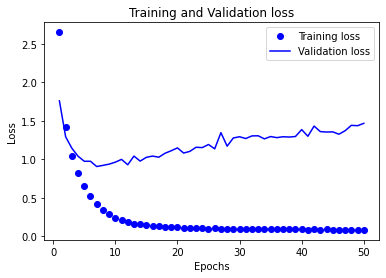

In [17]:
# 학습용과 검증용 데이터에 대한 손실과 정확도 출력
import matplotlib.pyplot as plt

loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=range(1,len(loss)+1)
plt.plot(epochs, loss, 'bo', label='Training loss') # bo : 파란색 점선
plt.plot(epochs, val_loss, 'b', label='Validation loss') # b : 파란색 실선
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

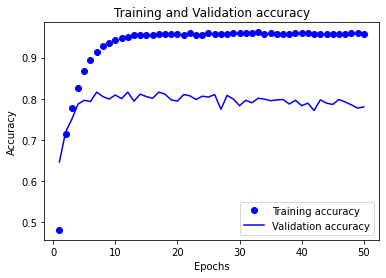

In [19]:
plt.clf()
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
plt.plot(epochs, acc, 'bo', label='Training accuracy') # bo : 파란색 점선
plt.plot(epochs, val_acc, 'b', label='Validation accuracy') # b : 파란색 실선
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [20]:
# 손실율과 정확도
results

[1.7036176919937134, 0.7729296684265137]

In [21]:
predictions=model.predict(x_test)

In [22]:
# 길이가 46인 벡터
predictions[0].shape

(46,)

In [23]:
# 이 벡터의 원소 합은 1
np.sum(predictions[0])

1.0000002

In [24]:
# 가장 확률이 높은 클래스
np.argmax(predictions[0])

3